In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d alessiocorrado99/animals10

100% 583M/586M [00:29<00:00, 22.8MB/s]
100% 586M/586M [00:29<00:00, 21.1MB/s]


In [ ]:
! unzip "/content/animals10.zip" -d "/content/dataset"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
dataset_dir = "/content/dataset/raw-img"
CONFIG = {
    "IM_SIZE" : 256,
    "BATCH_SIZE" : 32,
}

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle = True,
    subset = "training",
    validation_split = 0.2,
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle = True,
    subset = "validation",
    validation_split = 0.2,
)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


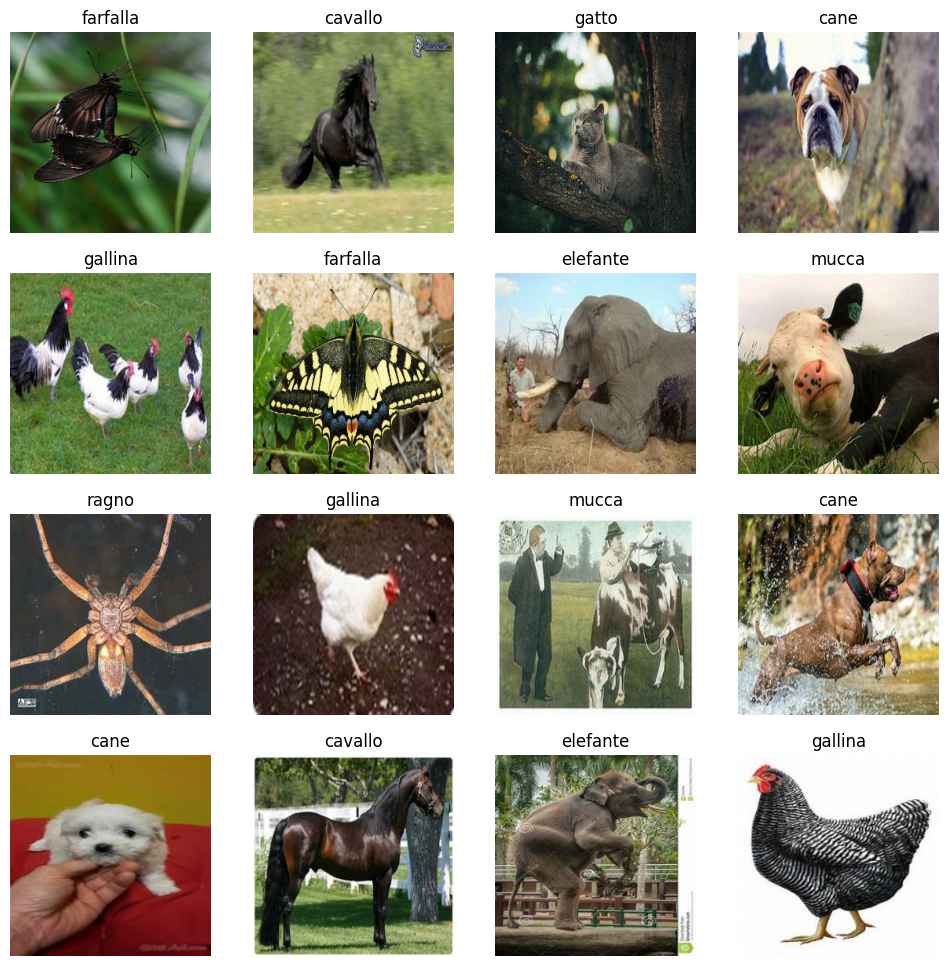

In [ ]:
plt.figure(figsize = (12,12))

for images,labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    plt.title(class_names[labels[i].numpy()])
    plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(f"Train size {len(train_ds)} Val Size {len(val_ds)}")
print(train_ds)
print(val_ds)

Train size 655 Val Size 164
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top = False,
    input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3),
    pooling = "avg",
    weights = "imagenet",
    classes=len(class_names)
)

for layer in pretrained_model.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet_model = tf.keras.models.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(len(class_names),activation = 'softmax')
])
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 1054218 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer="adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [ ]:
history = resnet_model.fit(train_ds,validation_data=val_ds,epochs = 10)

Epoch 1/10
655/655 [==============================] - 120s 160ms/step - loss: 0.2768 - accuracy: 0.9160 - val_loss: 0.1976 - val_accuracy: 0.9373
Epoch 2/10
655/655 [==============================] - 102s 154ms/step - loss: 0.1481 - accuracy: 0.9526 - val_loss: 0.2035 - val_accuracy: 0.9356
Epoch 3/10
655/655 [==============================] - 101s 154ms/step - loss: 0.0987 - accuracy: 0.9673 - val_loss: 0.1746 - val_accuracy: 0.9465
Epoch 4/10
655/655 [==============================] - 102s 155ms/step - loss: 0.0730 - accuracy: 0.9769 - val_loss: 0.1828 - val_accuracy: 0.9498
Epoch 5/10
655/655 [==============================] - 102s 154ms/step - loss: 0.0643 - accuracy: 0.9780 - val_loss: 0.2162 - val_accuracy: 0.9457
Epoch 6/10
655/655 [==============================] - 102s 155ms/step - loss: 0.0485 - accuracy: 0.9837 - val_loss: 0.2110 - val_accuracy: 0.9482
Epoch 7/10
655/655 [==============================] - 103s 156ms/step - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.2643 -

In [ ]:
resnet_model.evaluate(val_ds)

164/164 [==============================] - 21s 123ms/step - loss: 0.3065 - accuracy: 0.9450


[0.30652692914009094, 0.9449856877326965]

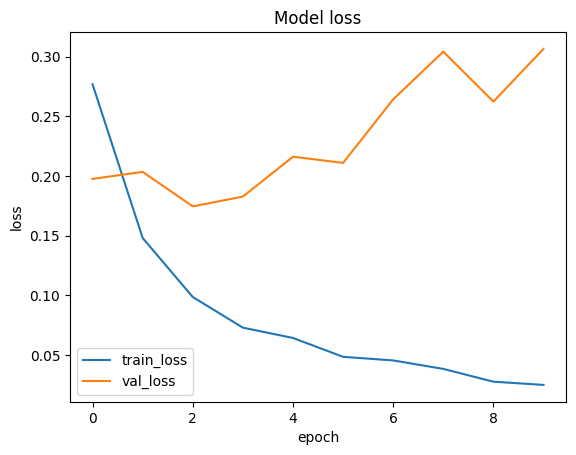

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_loss","val_loss"])
plt.show()

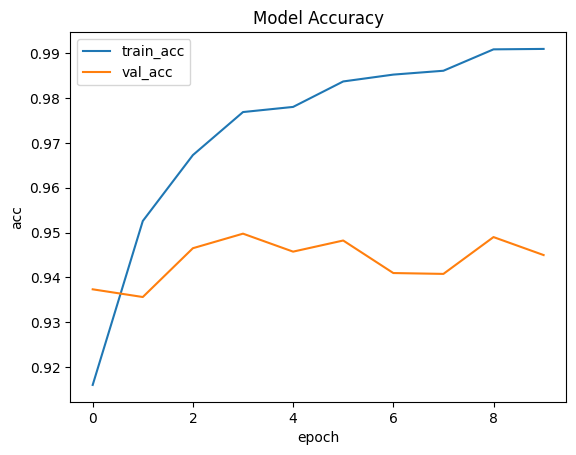

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(["train_acc","val_acc"])
plt.show()

In [ ]:
plt.figure(figsize = (14,14))

for images,labels in val_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    true_label = class_names[labels[i].numpy()]
    img_pred = tf.expand_dims(images[i],axis = 0)
    predict_label = resnet_model.predict(img_pred)
    plt.title(f"True: {true_label} \n Predict: {class_names[np.argmax(predict_label)]}")
    plt.axis("off")